In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from gensim.models import KeyedVectors
import gensim
import re
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../input/quora-ques-pair/test_data.csv/test_data.csv').fillna('')
val = pd.read_csv('../input/quora-ques-pair/val_data.csv/val_data.csv').fillna('')
test = pd.read_csv('../input/quora-ques-pair/test_data.csv/test_data.csv').fillna('')

In [3]:
word2vec_file = '../input/d/sandreds/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'

In [4]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_preprocessed,question2_preprocessed
0,204673,93885,307635,"If there is a God, where is He!","Why is god a ""He""?",0,"if there is a god , where is he !",why is god a `` he '' ?
1,17716,2093,15628,Do you believe that everything happens for a r...,Does everything happen for a reason?,1,do you believe that everything happens for a r...,does everything happen for a reason ?
2,291767,352623,413255,Will there always be web hosting that will sup...,Will there always be web hosting that supports...,1,will there always be web hosting that will sup...,will there always be web hosting that supports...
3,203758,59824,67971,What is the proof of Indian Army's surgical st...,Has India provided any proof of the surgical s...,1,what is the proof of indian army 's surgical s...,has india provided any proof of the surgical s...
4,41747,75326,75327,What do Indian Muslims think of Modi?,What do Indian Muslim think about PM Narendra ...,1,what do indian muslims think of modi ?,what do indian muslim think about pm narendra ...


In [5]:
def buildVocabulary(reviews):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, split=' ')
    tokenizer.fit_on_texts(reviews)
    return tokenizer

def getSequences(reviews, tokenizer, seq_maxlen):
    reviews_seq = tokenizer.texts_to_sequences(reviews)
    return np.array(tf.keras.preprocessing.sequence.pad_sequences(reviews_seq, maxlen=seq_maxlen))

word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file, binary = True)

def getEmbeddingWeightMatrix(word2idx):    
    embedding_matrix = np.zeros((len(word2idx)+1, 300))
    for word, i in tqdm(word2idx.items()):
       
        embedding_vector = word2vec_model[word] if word in word2vec_model else np.random.rand(1,300)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [6]:
tokenizer = buildVocabulary(train['question1'].tolist()+train['question2'].tolist()+val['question1'].tolist()+val['question2'].tolist()+test['question1'].tolist()+test['question2'].tolist())
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

x_train1 = getSequences(train['question1'], tokenizer, 200)
x_train2 = getSequences(train['question2'], tokenizer, 200)
y_train = tf.keras.utils.to_categorical(train['is_duplicate'])

x_val1 = getSequences(val['question1'], tokenizer, 200)
x_val2 = getSequences(val['question2'], tokenizer, 200)
y_val = tf.keras.utils.to_categorical(val['is_duplicate'])

x_test1 = getSequences(test['question1'], tokenizer, 200)
x_test2 = getSequences(test['question2'], tokenizer, 200)
y_test = tf.keras.utils.to_categorical(test['is_duplicate'])

67043


In [7]:
#embedding_vectors = loadGloveWordEmbeddings()
#print(len(embedding_vectors))

embedding_weight_matrix = getEmbeddingWeightMatrix(tokenizer.word_index)
print(embedding_weight_matrix.shape)

100%|██████████| 67042/67042 [00:00<00:00, 148076.38it/s]

(67043, 300)


In [8]:
#he_initializer = tf.keras.initializers.HeUniform()
inp1 = tf.keras.Input(shape=(x_train1.shape[1],))
inp2 = tf.keras.Input(shape=(x_train2.shape[1],))

inner1= tf.keras.layers.Embedding(input_dim=67043, output_dim=300, input_length=200, 
                                  weights=[embedding_weight_matrix], trainable=True)(inp1)
inner2= tf.keras.layers.Embedding(input_dim=67043, output_dim=300, input_length=200,
                                  weights=[embedding_weight_matrix], trainable=True)(inp2)


#inner = tf.keras.layers.concatenate([inner1+inner2, inner1-inner2, tf.math.multiply(inner1, inner2)], axis=-1)

inner1 = tf.keras.backend.sum(inner1, axis=1, keepdims=False)
inner2 = tf.keras.backend.sum(inner2, axis=1, keepdims=False)
inner = inner1+inner2
inner = tf.keras.layers.Dense(200, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(inner)
inner = tf.keras.layers.Dropout(0.2)(inner)
inner = tf.keras.layers.Dense(120, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(inner)
inner = tf.keras.layers.Dropout(0.2)(inner)
inner = tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(inner)
inner = tf.keras.layers.Dropout(0.2)(inner)
output = tf.keras.layers.Dense(2, activation='softmax')(inner)

model = tf.keras.Model(inputs = [inp1, inp2], outputs = output)

2021-12-05 06:43:05.301034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 06:43:05.400333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 06:43:05.401024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 06:43:05.402338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     20112900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     20112900    input_2[0][0]                    
______________________________________________________________________________________________

In [10]:
save_weights = tf.keras.callbacks.ModelCheckpoint('cbow_mlp.h5', monitor='val_loss', save_best_only=True)
checkpoint_filepath = 'weights.best.{epoch:01d}.hdf5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#verbose = 1,
#monitor = 'val_loss',
#save_best_only = False)
history = model.fit((x_train1, x_train2), y_train,
                    batch_size = 64,
                    validation_data = ((x_val1, x_val2), y_val),
                    validation_batch_size = 64,
                    epochs=4, 
                    callbacks=[save_weights], 
                    verbose=1)

2021-12-05 06:43:08.036642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
632/632 [==============================] - 14s 20ms/step - loss: 1.5897 - accuracy: 0.6573 - val_loss: 0.6889 - val_accuracy: 0.6883
Epoch 2/4
632/632 [==============================] - 13s 20ms/step - loss: 0.5678 - accuracy: 0.7383 - val_loss: 0.5906 - val_accuracy: 0.7223
Epoch 3/4
632/632 [==============================] - 12s 19ms/step - loss: 0.4759 - accuracy: 0.7885 - val_loss: 0.5830 - val_accuracy: 0.7369
Epoch 4/4
632/632 [==============================] - 12s 19ms/step - loss: 0.4199 - accuracy: 0.8166 - val_loss: 0.6234 - val_accuracy: 0.7322


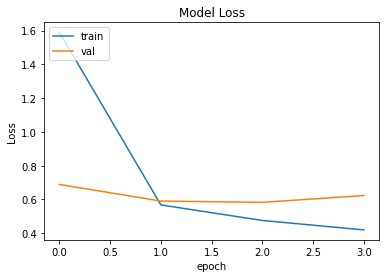

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

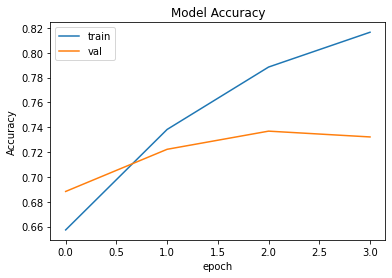

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
loss, accuracy = model.evaluate((x_test1, x_test2), y_test, batch_size=4, verbose=1)

print('loss on test data is', loss)
print('accuracy on test data is', accuracy)

10108/10108 [==============================] - 22s 2ms/step - loss: 0.3327 - accuracy: 0.8621
loss on test data is 0.3327052593231201
accuracy on test data is 0.8620792031288147


In [14]:
pred = model.predict((x_test1, x_test2))
print('F1_score on test is', f1_score(np.argmax(pred, axis=1), np.argmax(y_test, axis=1)))


F1_score on test is 0.7974573192880495
